# NumPyro Sample 実行

## Libs

In [18]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

import random
import string

In [19]:
jax.devices()

[CpuDevice(id=0)]

In [20]:
rng = np.random.default_rng(42)
n = 340000

ab_status = random.choices('ABX', weights = (33, 33, 34),  k = n)
uu_id = ["".join([random.choice(string.ascii_lowercase + string.digits) for _ in range(30)]) for _ in range(n)]
cv_flg = rng.binomial(n = 1, p = 0.2, size = n)

df = pd.DataFrame(zip(ab_status, uu_id, cv_flg), columns = ['ab_status', 'uu_id', 'cv_flg'])

In [21]:
y = df.query('ab_status == "X"')['cv_flg'].values

## Model 定義

In [22]:
def model(y = None, num_data = 0):

    # パラメーターの事前分布
    mu = numpyro.sample('mu', dist.HalfNormal(10))

    # 観測データ（Y）に基づく尤度の定義
    with numpyro.plate('data', num_data):
        
        numpyro.sample('obs', dist.Poisson(mu), obs = y)

## 推論

In [23]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)
mcmc.run(jax.random.PRNGKey(42), y = y, num_data = len(y))
mcmc_samples = mcmc.get_samples()

/var/folders/03/smvv0jp54c5cnt0xtqz_1gkc0000gn/T/ipykernel_67765/2570005247.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)
sample: 100%|█| 3500/3500 [00:01<00:00, 1969.24it/s
sample: 100%|█| 3500/3500 [00:01<00:00, 3199.82it/s
sample: 100%|█| 3500/3500 [00:00<00:00, 3732.38it/s
sample: 100%|█| 3500/3500 [00:00<00:00, 3758.56it/s


## 分析準備

In [24]:
# InferenceData オブジェクトへの変換（az のフォーマットに変換してあげるだけ）
idata = az.from_numpyro(mcmc)

## 収束チェック

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

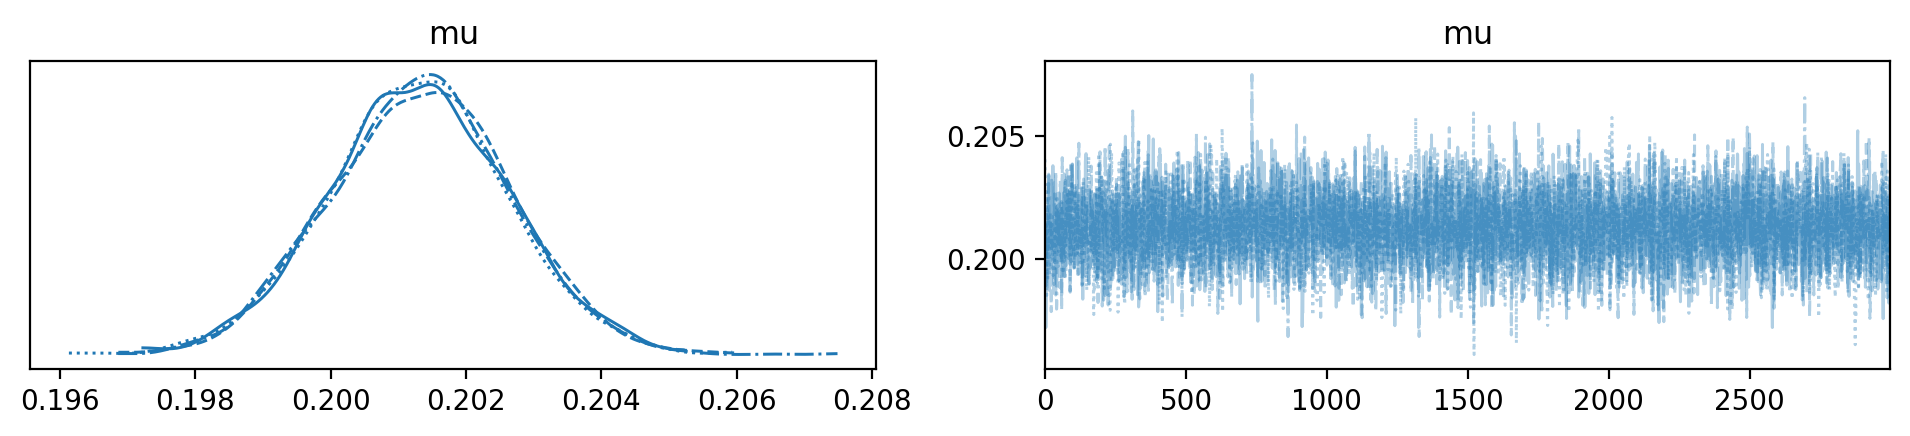

In [25]:
az.plot_trace(idata)

In [26]:
# 基本的には R hat が 1.1未満ならOK
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.201,0.001,0.199,0.204,0.0,0.0,4814.0,5867.0,1.0


<Axes: title={'center': 'mu'}>

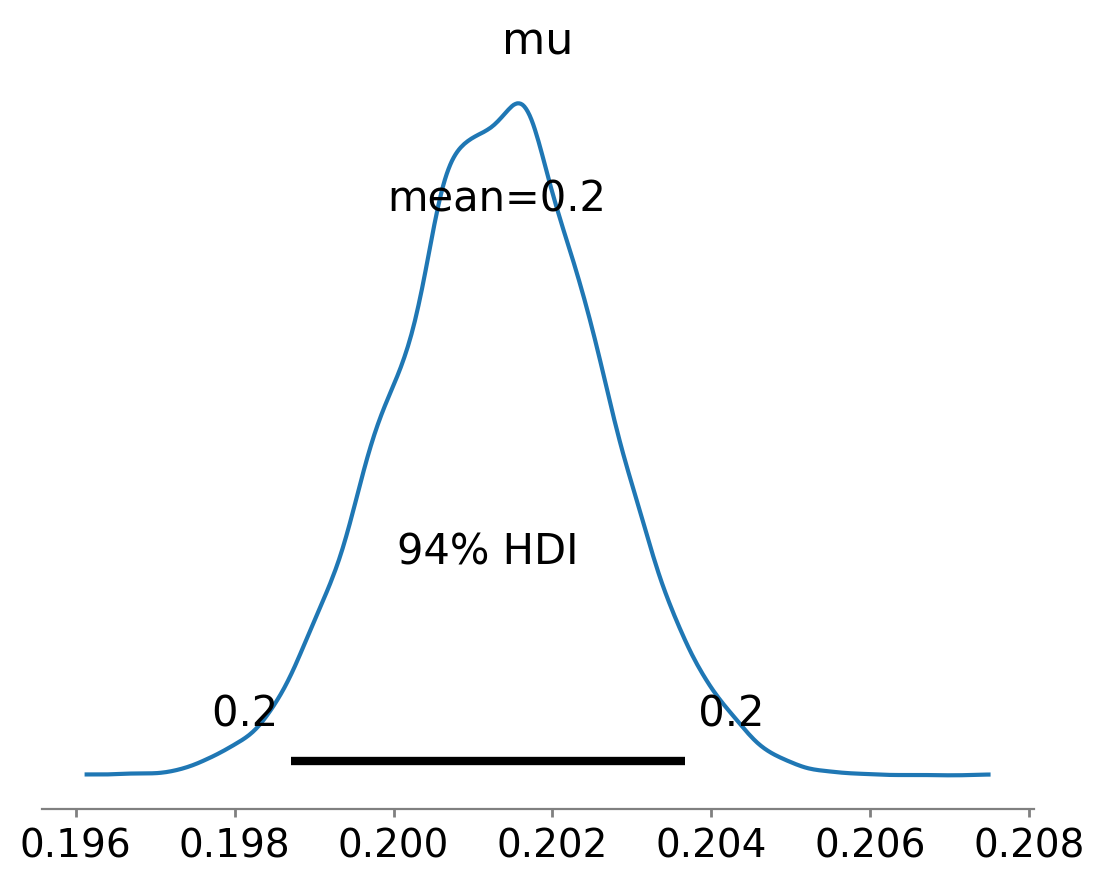

In [27]:
# 基本的には HDI をチェック（Highest Density Interval 最高密度区間 の略）実際にMCMCサンプリングした94%がここに入ってるよていう話
az.plot_posterior(idata)

## 事後予測チェック（PPC：Post Predictive Check）
model がちゃんと真のパラメーターを説明できているかどうか

In [34]:
predictive = numpyro.infer.Predictive(model, mcmc_samples)
ppc_samples = predictive(jax.random.PRNGKey(42), num_data = len(y))

In [35]:
idata_ppc = az.from_numpyro(mcmc, posterior_predictive = ppc_samples)

In [36]:
ppc_mean = ppc_samples['obs'].mean(axis = 1)
ppc_var = ppc_samples['obs'].var(axis = 1)

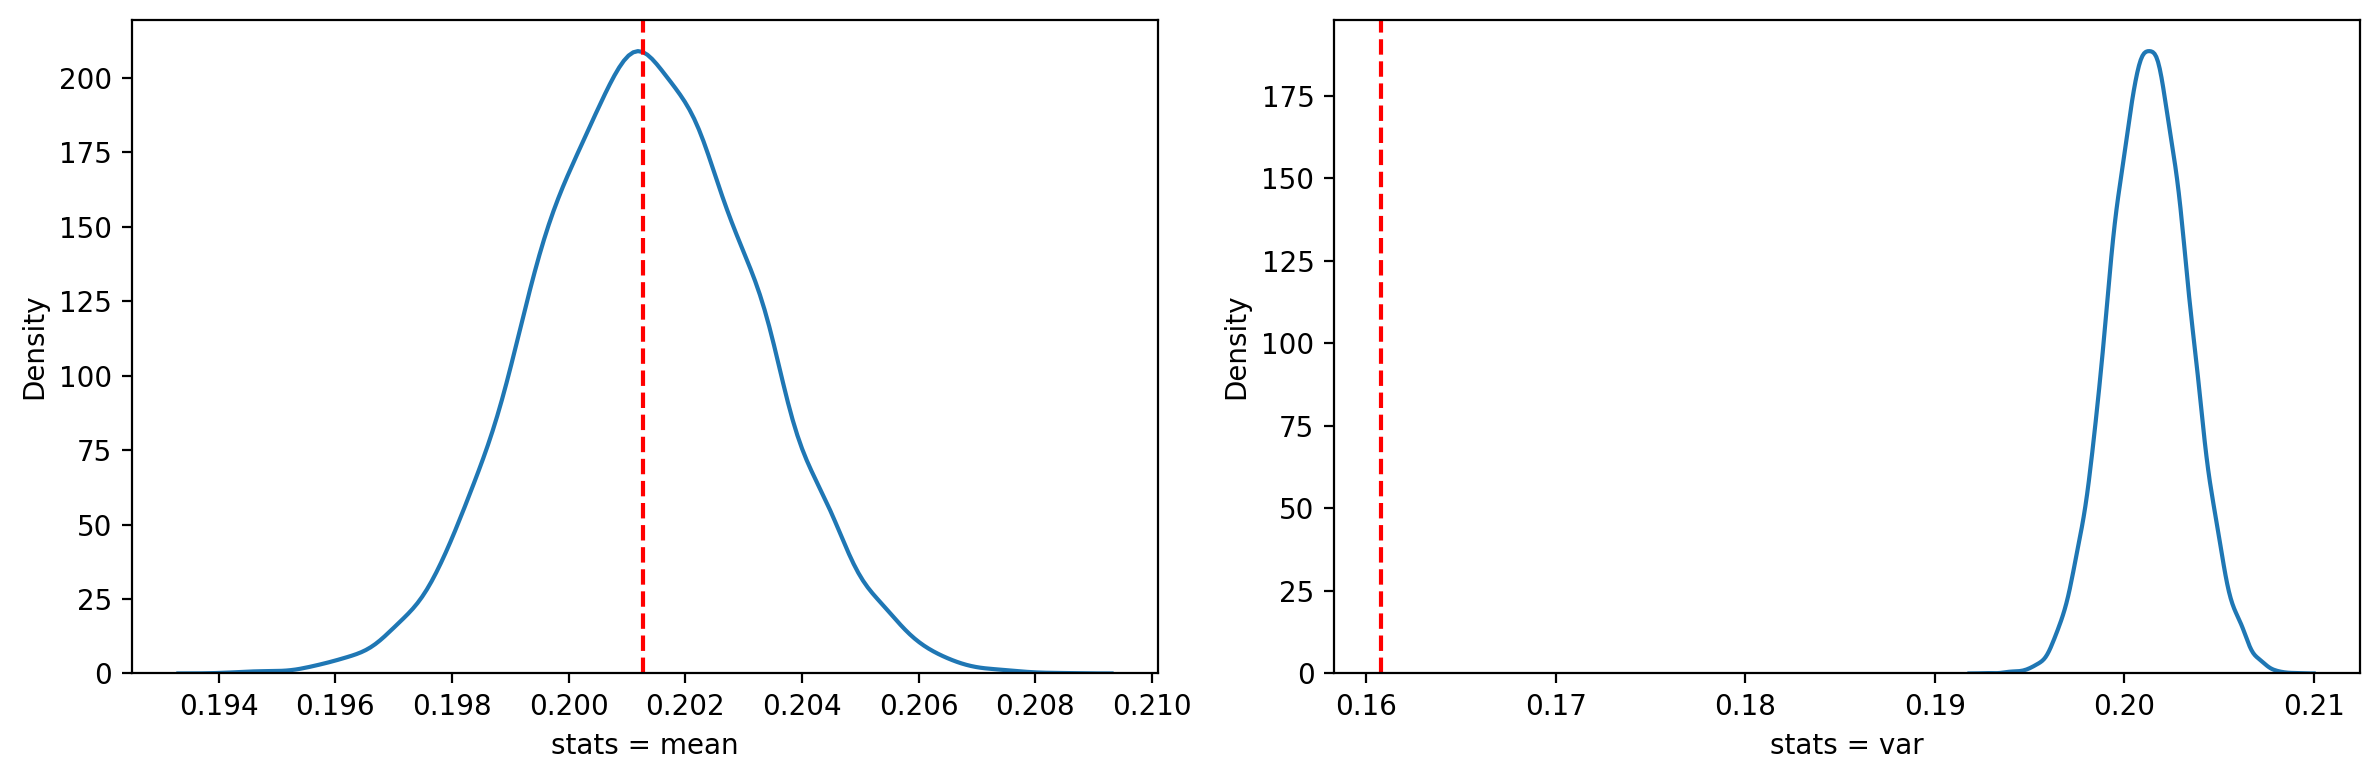

In [41]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.kdeplot(ppc_mean, ax = axes[0])
axes[0].axvline(y.mean(), color = 'r', linestyle = 'dashed')
axes[0].set_xlabel('stats = mean')

sns.kdeplot(ppc_var, ax = axes[1])
axes[1].axvline(y.var(), color = 'r', linestyle = 'dashed')
axes[1].set_xlabel('stats = var')

plt.tight_layout()

In [43]:
idata_ppc

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

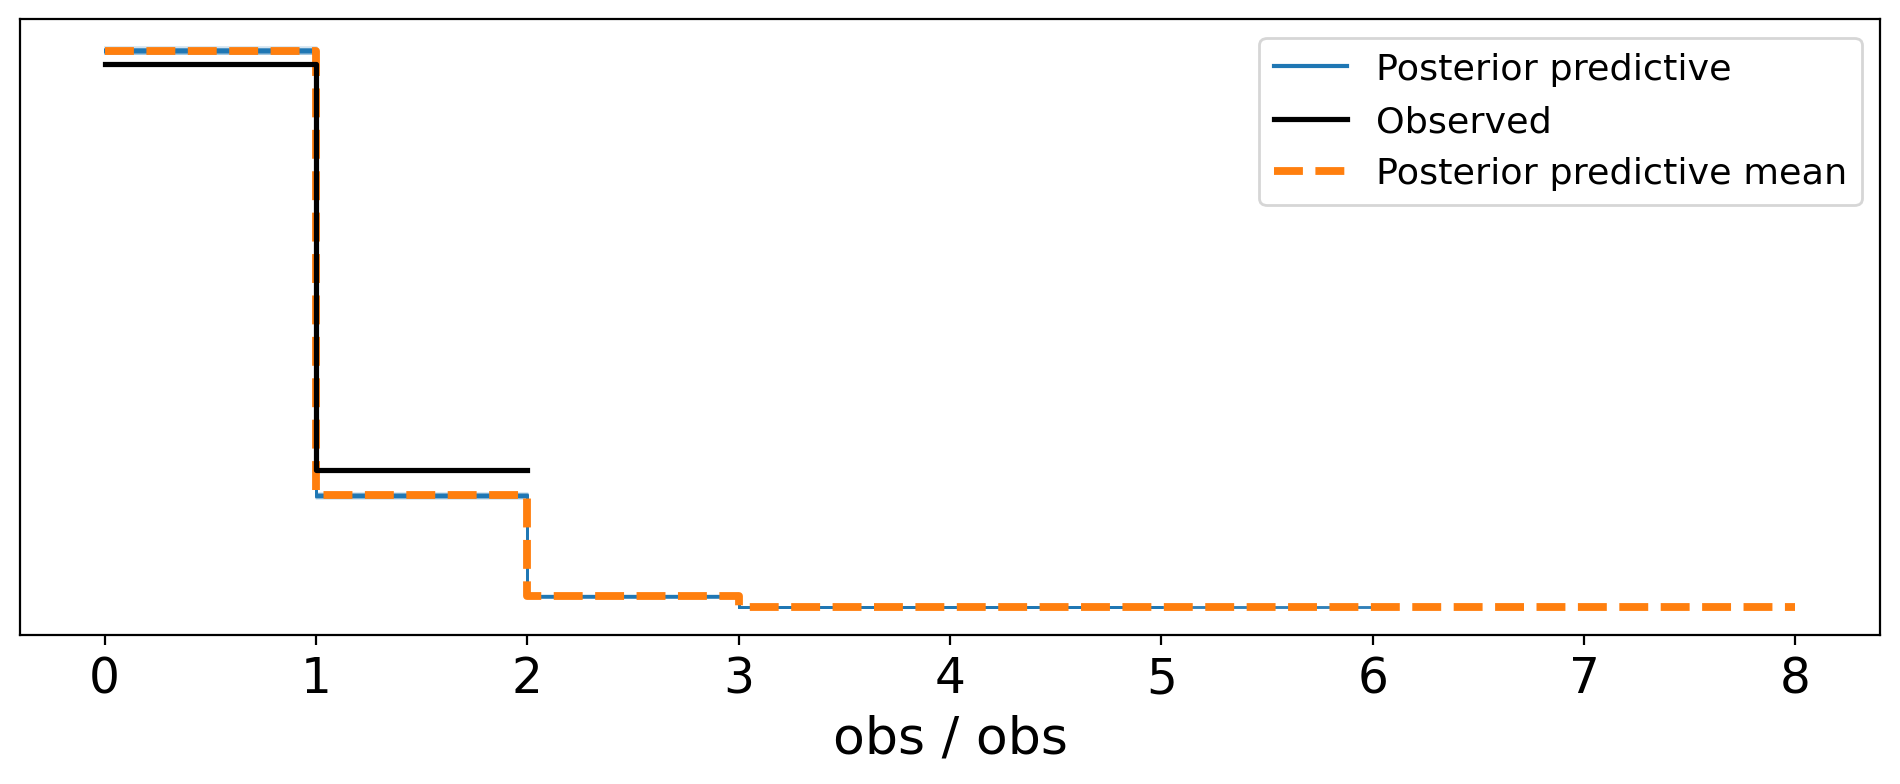

In [47]:
az.plot_ppc(idata_ppc, kind = 'kde', num_pp_samples = 50, figsize = (12,4));

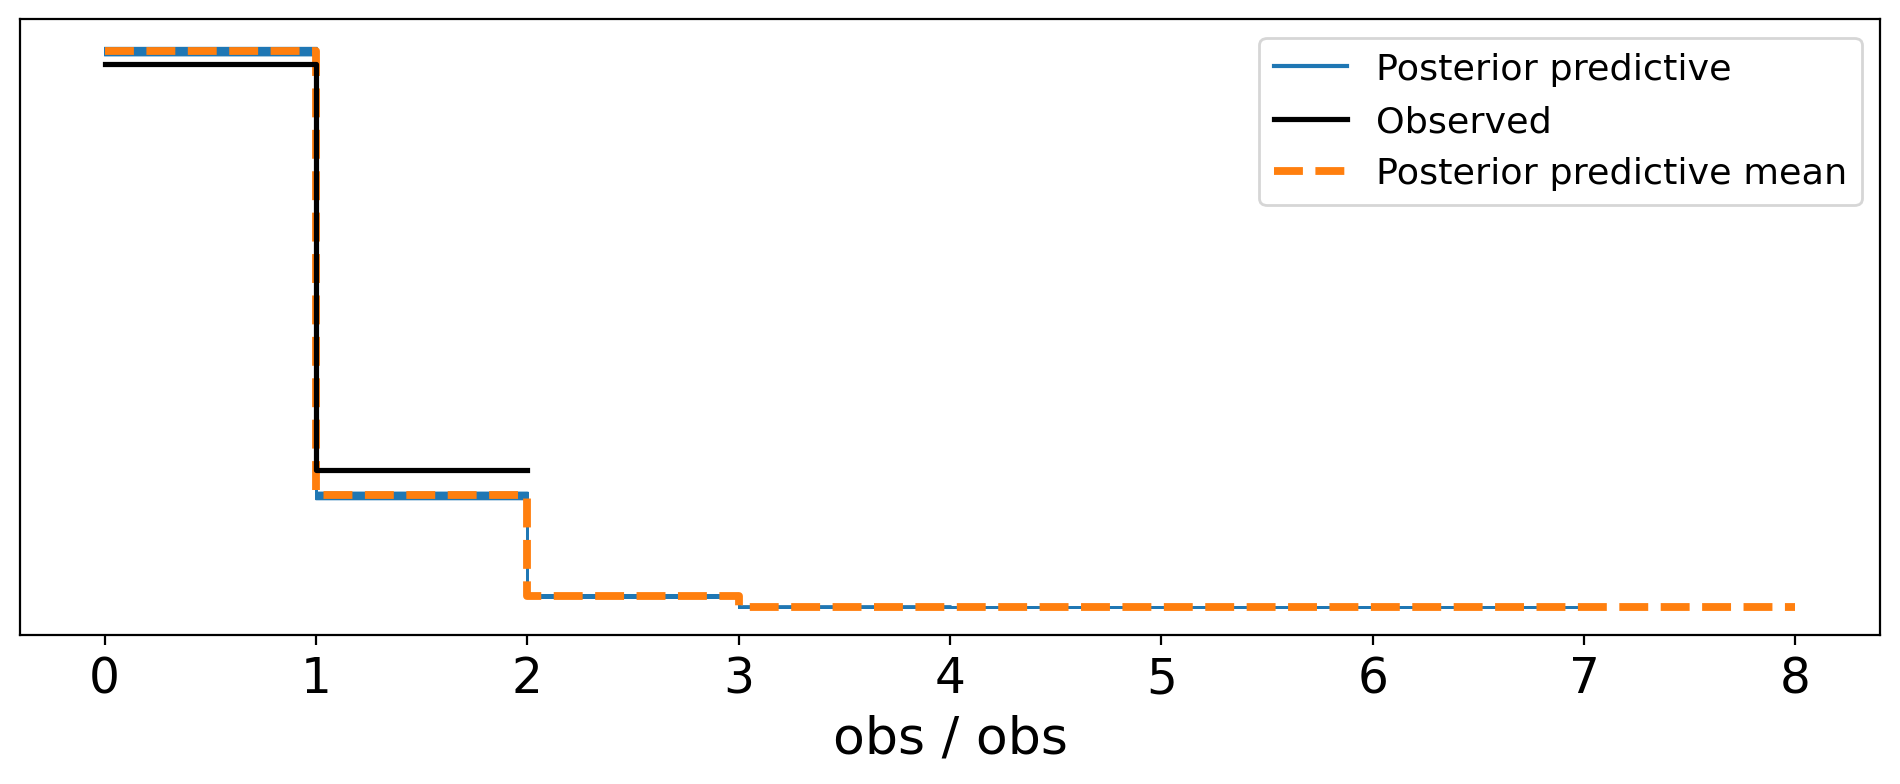

In [48]:
az.plot_ppc(idata_ppc, kind = 'kde', num_pp_samples = 3000, figsize = (12,4));

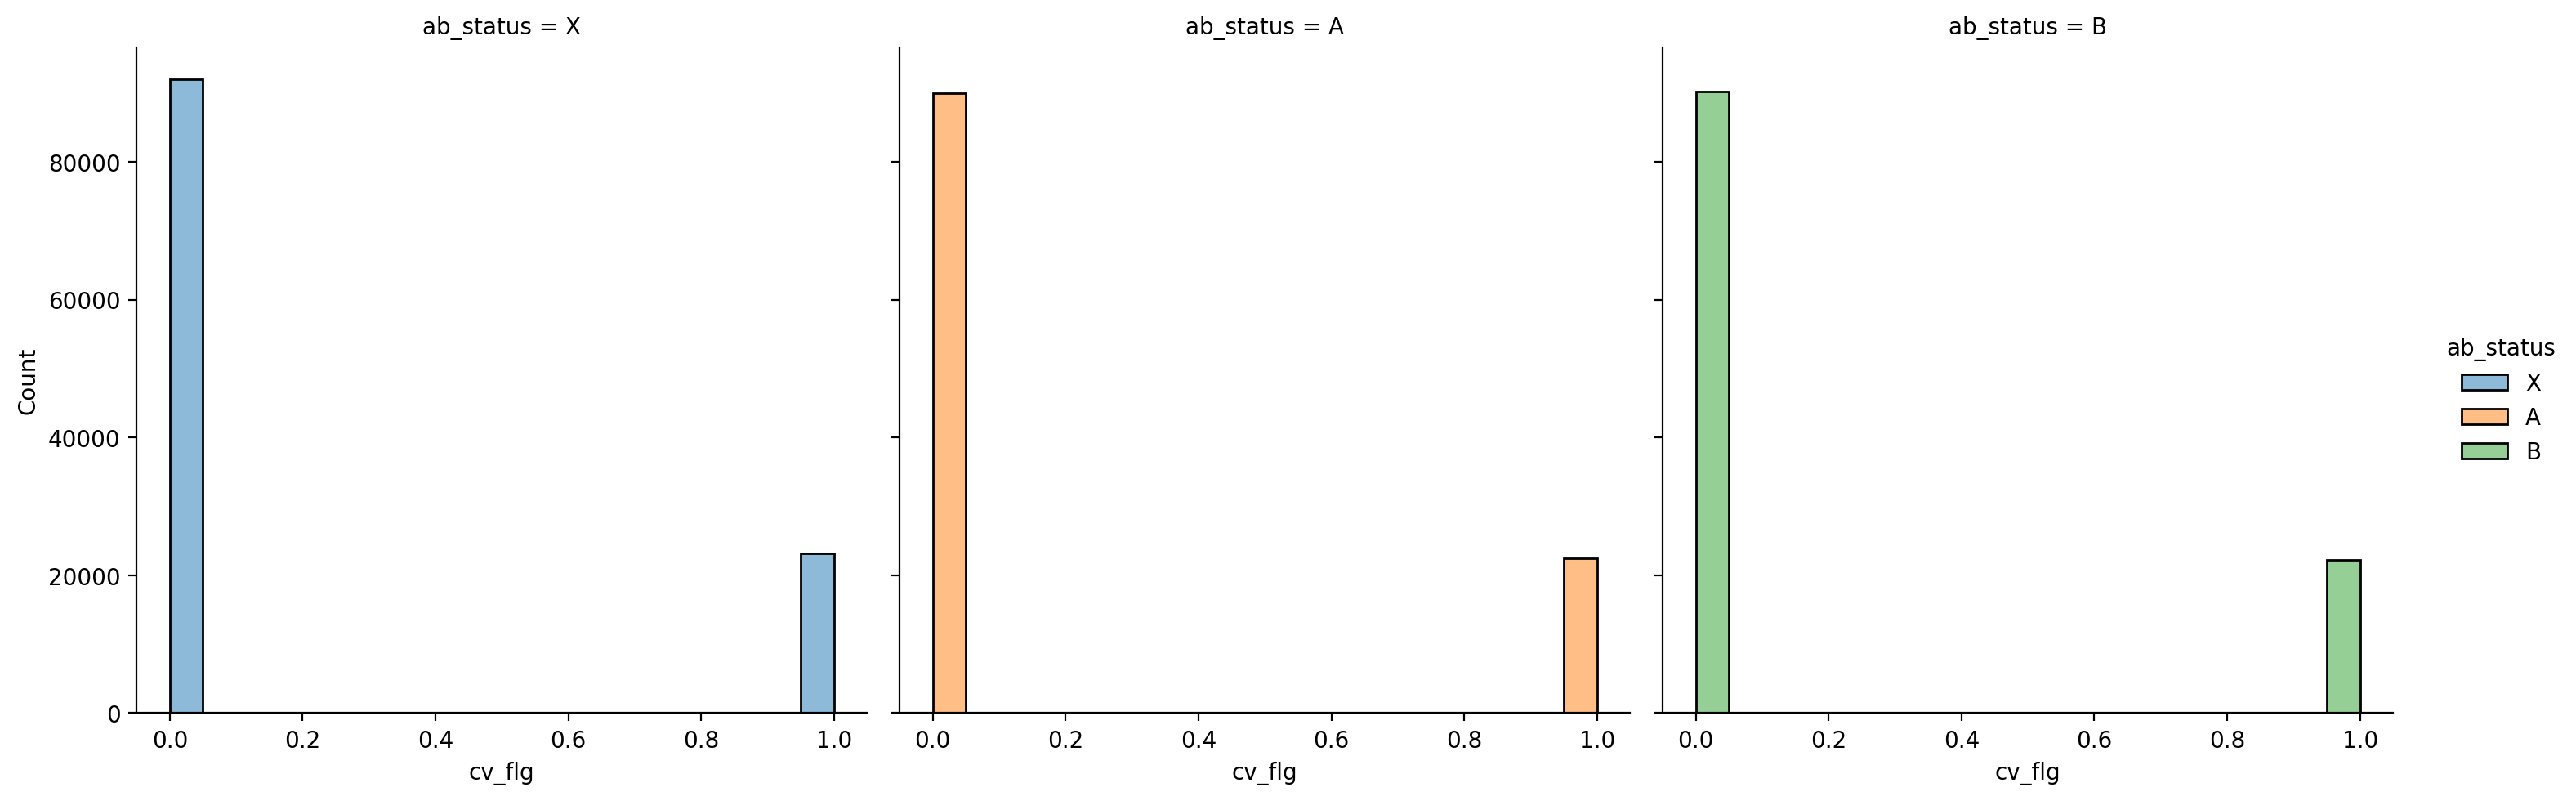

In [50]:
sns.displot(data = df, x = 'cv_flg', hue = 'ab_status', col = 'ab_status');